# Tutorial 9: Learning Rate Controller

In this tutorial, we are going to show you how to use a specific Trace - `LRController` to change your learning rate during the training.  In general, `LRController` takes care of both learning rate scheduling as well as changing learning rate on validation.

If you are a keras user, `LRController` is a combination of LRScheduler and ReduceLROnPlateau

## Preparation

In [ ]:
import numpy as np
import tensorflow as tf
import fastestimator as fe
from fastestimator.architecture import LeNet
from fastestimator.network.loss import SparseCategoricalCrossentropy
from fastestimator.network.model import FEModel, ModelOp
from fastestimator.pipeline.processing import Minmax
import matplotlib.pyplot as plt

def get_pipeline_network():
    # step 1. prepare data
    (x_train, y_train), (x_eval, y_eval) = tf.keras.datasets.mnist.load_data()
    train_data = {"x": np.expand_dims(x_train, -1), "y": y_train}
    eval_data = {"x": np.expand_dims(x_eval, -1), "y": y_eval}
    data = {"train": train_data, "eval": eval_data}
    pipeline = fe.Pipeline(batch_size=32, data=data, ops=Minmax(inputs="x", outputs="x"))

    # step 2. prepare model
    model = FEModel(model_def=LeNet, model_name="lenet", optimizer="adam")
    network = fe.Network(ops=[ModelOp(inputs="x", model=model, outputs="y_pred"), 
                              SparseCategoricalCrossentropy(inputs=("y", "y_pred"))])
    return pipeline, network

def plot_lr(history, lr_name="lenet_lr"):
    lr_list = [(k, v) for k, v in history.history["train"][lr_name].items()] 
    step = [x[0] for x in lr_list]
    lr = [x[1] for x in lr_list]
    plt.plot(step, lr)
    plt.xlabel("step")
    plt.ylabel("lr")

## Customize learning rate: step-wise control

Let's define our learning rate scheduler to be 0.001 * (1 + step // 500)

In [2]:
from fastestimator.estimator.trace import LRController
from fastestimator.network.lrschedule import LRSchedule

class MyLRSchedule1(LRSchedule):
    def schedule_fn(self, current_step_or_epoch, lr):
        lr = 0.001 * (1 + current_step_or_epoch // 500)
        return lr

pipeline1, network1 = get_pipeline_network()
lr_scheduler1 = MyLRSchedule1(schedule_mode="step")
estimator1 = fe.Estimator(pipeline=pipeline1, 
                         network=network1, 
                         epochs=2,
                         traces=LRController(model_name="lenet", lr_schedule=lr_scheduler1))

In [ ]:
history1 = estimator1.fit(summary="custom_lr_scheduler_step")

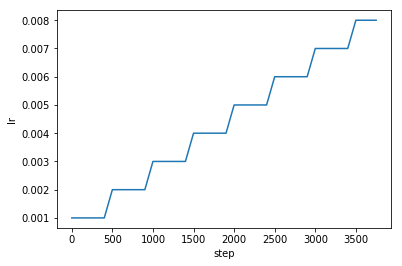

In [4]:
plot_lr(history1)

## Customize learning rate: epoch-wise control

Let's define learning rate to be (epoch +1 ) * 0.002

In [5]:
from fastestimator.estimator.trace import LRController
from fastestimator.network.lrschedule import LRSchedule

class MyLRSchedule2(LRSchedule):
    def schedule_fn(self, current_step_or_epoch, lr):
        lr = 0.002 * (1 + current_step_or_epoch)
        return lr

pipeline2, network2 = get_pipeline_network()
lr_scheduler2 = MyLRSchedule2(schedule_mode="epoch")
estimator2 = fe.Estimator(pipeline=pipeline2, 
                         network=network2, 
                         epochs=2,
                         traces=LRController(model_name="lenet", lr_schedule=lr_scheduler2))

In [ ]:
history2 = estimator2.fit(summary="custom_lr_scheduler_epoch")

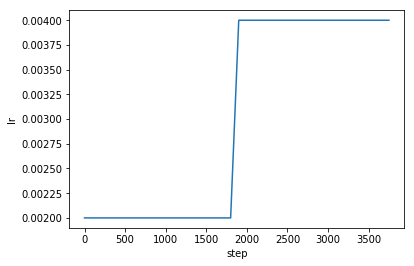

In [7]:
plot_lr(history2)

## Built-in Cyclic Learning Rate: example1

As always, we implement many popular learning rate shedules for users, `CyclicLRSchedule` is a generalization of many learning rate schedules.

In the next example, let's decay the learning rate like half of cosine curve.

In [8]:
from fastestimator.estimator.trace import LRController
from fastestimator.network.lrschedule import CyclicLRSchedule

pipeline3, network3 = get_pipeline_network()
estimator3 = fe.Estimator(pipeline=pipeline3, 
                         network=network3, 
                         epochs=2,
                         traces=LRController(model_name="lenet", 
                                             lr_schedule=CyclicLRSchedule(num_cycle=1, decrease_method="cosine")))

In [ ]:
history3 = estimator3.fit(summary="cyclic_1")

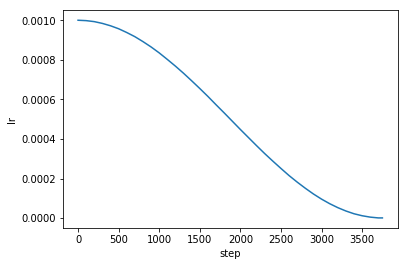

In [10]:
plot_lr(history3)

## Built-in Cyclic Learning Rate: example 2

user can choose to add more cycles of the learning rate, also change the multiplier of subsequent cycle length:

In [11]:
from fastestimator.estimator.trace import LRController
from fastestimator.network.lrschedule import CyclicLRSchedule

pipeline4, network4 = get_pipeline_network()
estimator4 = fe.Estimator(pipeline=pipeline4, 
                         network=network4, 
                         epochs=2,
                         traces=LRController(model_name="lenet", 
                                             lr_schedule=CyclicLRSchedule(num_cycle=2, 
                                                                          cycle_multiplier=2, 
                                                                          decrease_method="cosine")))

In [ ]:
history4 = estimator4.fit(summary="cyclic_2")

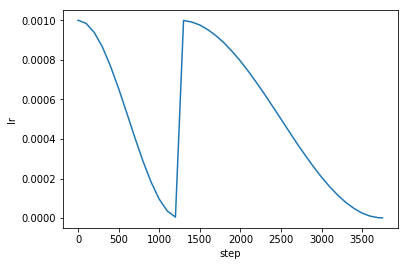

In [13]:
plot_lr(history4)